In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

from Function.Stimulation_GPU import *
from Function.ReceptiveField_GPU import *
from Function.plot_SNN import *
from Function.SNN_230327 import SNNModel
from Function.SNNModule import *


In [2]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

GPU available: True
CUDA version: 10.1


In [3]:
# # on mac
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
# print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
# print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
# !python -c 'import platform;print(platform.platform())'

In [4]:
sensor_h, sensor_w = 19, 16 #(mm)
pixel_h, pixel_w = 64, 48 # (#)
img_FPS = 60

In [5]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_left2right = torch.zeros(
    (pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/16
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, r=2)
    stimulation_left2right[:, :, i] = stim_dot

    # if i % 200 == 0:
    #     plt.imshow(stimulation_left2right[:, :, i].cpu(), cmap='jet')
    #     plt.show()
print(stimulation_left2right.device)

cpu


In [6]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 20
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, w=2)
    stimulation_angle_0[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='jet')

    #     plt.show()
print(stimulation_angle_0.device)

cpu


In [7]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 20
for i in range(num_stim):
    x0 = i * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, theta=np.pi/2, w=2)
    stimulation_angle_90[:, :, i] = stim_dot
    # if i % 100 == 0:
    #     plt.imshow(stimulation_angle_90[:, :, i].cpu(), cmap='jet')
    #     plt.colorbar()
    #     plt.show()
print(stimulation_angle_90.device)

cpu


In [8]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_drop = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    if i < 500:
        x0 = 8  # Move the stimulus by 0.3mm for each frame
        y0 = 9
    else:
        x0 = 8
        y0 = i*0.3/15
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, r=1)
    stimulation_drop[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_drop[:, :, i].cpu(), cmap='jet')
    #     plt.show()

print(stimulation_drop.device)


cpu


In [9]:
num_stim = 1000

# Generate the sequence of F values
max_F = 10
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])

# Preallocate the stimulation_full array
stimulation_full = torch.zeros((pixel_h, pixel_w, num_stim),device = device)

# Create a color map with a range of 0 to max_F
cmap = plt.cm.get_cmap('jet')
cmap.set_under('k')

# Iterate over F_array and generate the stimuli
for i, F_i in enumerate(F_array):
    stim_dot = full_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w)
    stimulation_full[:, :, i] = stim_dot
    
    # if i % 200 == 0:
    #     plt.imshow(stimulation_full[:, :, i].cpu(),
    #                cmap=cmap, vmin=0, vmax=max_F)
        
    #     plt.show()
print(stimulation_full.device)

cpu


c:\Users\JaehunKim\anaconda3\envs\pytorch-CUDA10.1\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))


In [10]:
SA_rf,[SA_top_h,SA_top_v] = generate_mechanoreceptor_to_afferent_rf()
RA_rf,[RA_top_h,RA_top_v] = generate_mechanoreceptor_to_afferent_rf(kernel_w=15, kernel_h=15)

print(SA_rf.shape)

# receptive_field_optimized = [torch.tensor([[8, -4], [8, -4], [8, -4], [8, -4], [8, -4]], device=device),
#                              torch.tensor(
#                                  [[8, 8, 8, 8, 8], [-4, -4, -4, -4, -4]], device=device),
#                              12 * torch.ones((7, 7), device=device)
#                             ]

# receptive_field_optimized = [torch.tensor([[0.5, 1, 0.5], [1, 2, 1], [0.5, 1, 0.5]], device=device)*3]

# receptive_field_optimized = [torch.tensor([[8, -4], [8, -4], [8, -4], [8, -4], [8, -4]], device=device),
#                              torch.tensor(
#                                  [[8, 8, 8, 8, 8], [-4, -4, -4, -4, -4]], device=device),
#                              12 * torch.ones((7, 7), device=device),
#                              torch.tensor([[0.5, 1, 0.5], [1, 2, 1], [
#                                           0.5, 1, 0.5]], device=device)*3,
#                              torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], device=device)*10,  # Sobel horizontal
#                              torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=device)*10,  # Sobel vertical
#                              torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*10,  # Prewitt horizontal
#                              torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*10,  # Prewitt vertical
# ]

receptive_field_optimized = [
                             torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], device=device)*10,  # Prewitt horizontal
                             torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], device=device)*10,  # Prewitt vertical
]

synaptic_delays_top = [
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
    torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]], device=device),
]

SA_rf_top, SA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=SA_top_v,
                                                                            pixel_w=SA_top_h, step_size=1, device = device)

RA_rf_top, RA_rf_length = generate_afferent_to_top_rf(receptive_field_optimized, pixel_h=RA_top_v,
                                                                              pixel_w=RA_top_h, step_size=1, device = device)

SA_rf_top_delay, SA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=SA_top_v,
                                              pixel_w=SA_top_h, step_size=1, device=device)

RA_rf_top_delay, RA_rf_top_delay_length = generate_afferent_to_top_rf(synaptic_delays_top, pixel_h=RA_top_v,
                                                      pixel_w=RA_top_h, step_size=1, device=device)

print(SA_rf_length)
print(RA_rf_length)
print(SA_rf_top.device)

Complete! Generated 70 receptive fields from mechanoreceptor to afferents with kernel size 10x10.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 15x15.
torch.Size([70, 3072])
Complete! Generated 80 receptive fields from afferents to the top with kernel size 3x3. with step size 7x4
Complete! Generated 56 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
Complete! Generated 80 receptive fields from afferents to the top with kernel size 3x3. with step size 7x4
Complete! Generated 56 receptive fields from afferents to the top with kernel size 3x3. with step size 6x3
[40, 40]
[28, 28]
cpu


In [11]:
# Create Izhikevich layers
SA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_rf), a_decay=1 ,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 8, len(SA_rf_top), a_decay=1,device=device)
    ]

# Create synapses
SA_synapses = [
    Synapse(SA_rf.to(device), RA_rf_top_delay, device=device),
    Synapse(SA_rf_top.to(device), SA_rf_top_delay, device=device)
    ]

RA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_rf), a_decay=1,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_rf_top), a_decay=1,device=device)
    ]

RA_synapses =[
    Synapse(RA_rf.to(device),RA_rf_top_delay,device = device),
    Synapse(RA_rf_top.to(device),RA_rf_top_delay,device = device)
    ]
    


layer initialized
layer initialized
layer initialized
layer initialized


In [12]:
print(SA_layers[0].v.shape)
print(SA_layers[0].u.shape)
print(SA_layers[1].v.shape)

torch.Size([70])
torch.Size([70])
torch.Size([80])


In [15]:
def run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu'):
    SA = SNNModel(SA_layers,SA_synapses,device)
    RA = SNNModel(RA_layers,RA_synapses,device)


    SA_stim = stim * 2
    RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 50

    SA_spike_times = SA.feedforward(SA_stim,plot_spikes=True)
    RA_spike_times = RA.feedforward(RA_stim)

    plt.plot(SA_stim[1,1,:].cpu().numpy())
    plt.plot(RA_stim[1, 1, :].cpu().numpy())

    plot_spike_times(SA.spike_times[0])
    print(SA.spike_times[0].shape)
    plt.imshow(torch.sum(SA.spike_times[0],axis=1).reshape(19,13),cmap='jet',vmin=0,vmax=500)
    plt.colorbar()
    plt.show()

    st_ind = 0
    for i in SA_rf_length:
        if i != 0:
            plot_spike_times(SA.spike_times[1][st_ind:st_ind + i],'orange',size = (5,3*i/57))
            plt.imshow(torch.sum(SA.spike_times[1][st_ind:st_ind + i], axis=1).reshape(8,5),cmap='jet',vmin=0,vmax=300)
            plt.colorbar()
            plt.show()
            st_ind = st_ind + i


    plot_spike_times(RA.spike_times[0])
    st_ind = 0
    for i in RA_rf_length:
        if i != 0:
            print(st_ind,st_ind+i)
            plot_spike_times(RA.spike_times[1][st_ind:st_ind + i],'g',size = (5,3*i/57))
            st_ind = st_ind + i

Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


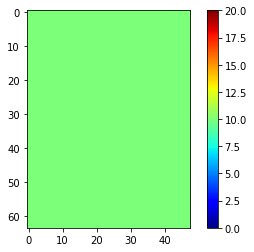

RuntimeError: shape '[19, 13]' is invalid for input of size 70

In [16]:
stim = stimulation_full.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device=device)
end_time = time.time()

print(end_time - start_time)

Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


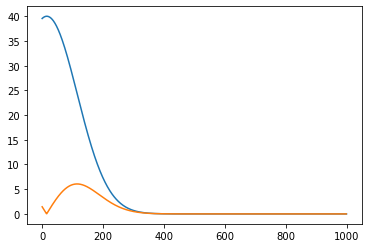

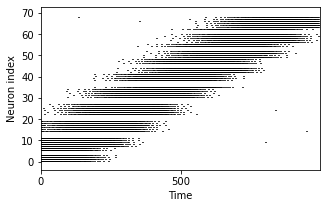

torch.Size([70, 999])


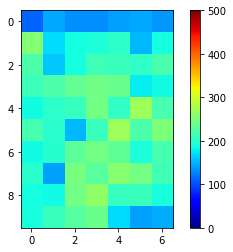

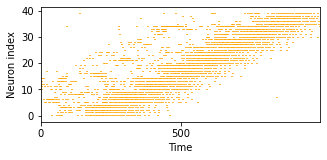

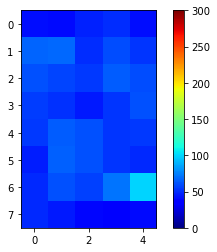

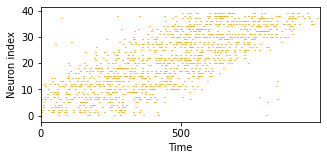

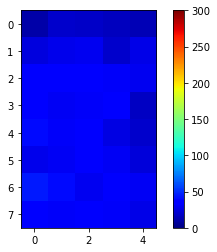

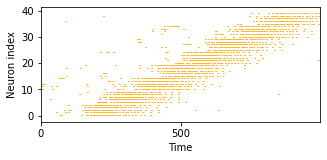

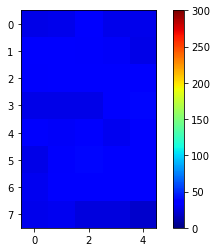

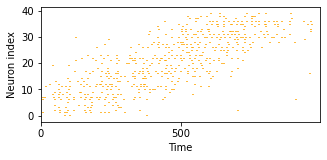

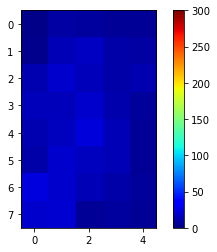

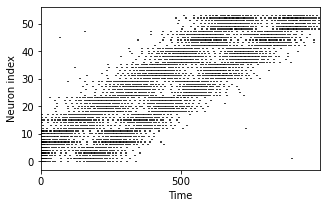

0 28


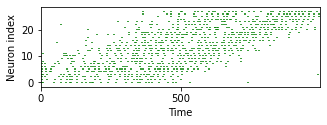

28 56


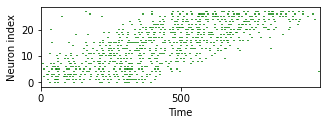

56 84


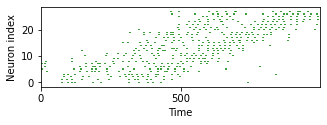

84 112


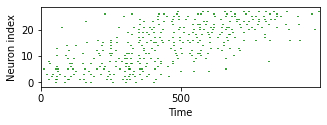

2.464489221572876


In [ ]:
stim = stimulation_angle_0.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
               SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)



Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


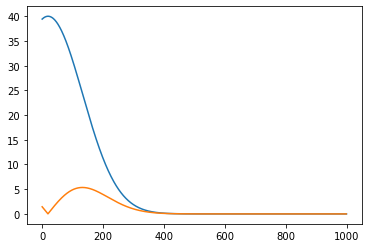

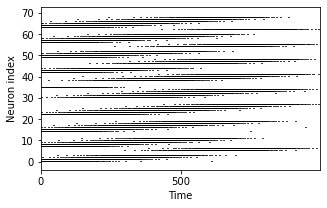

torch.Size([70, 999])


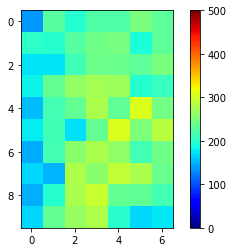

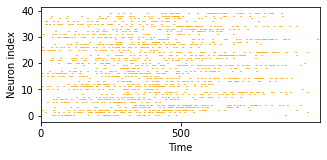

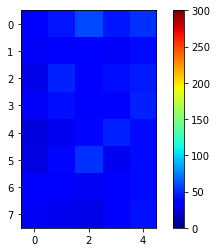

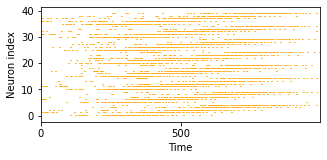

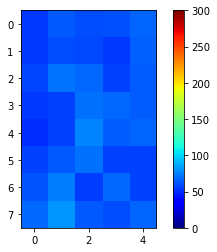

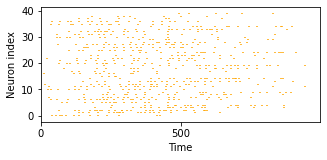

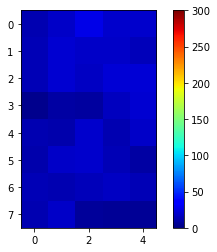

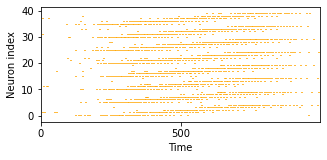

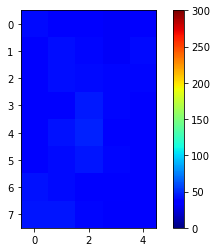

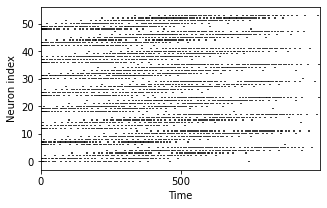

0 28


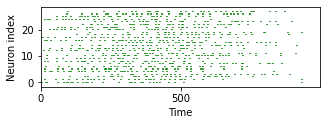

28 56


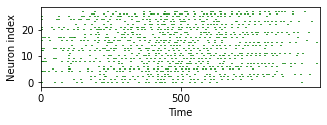

56 84


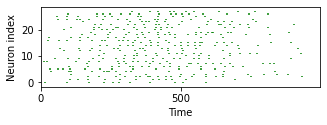

84 112


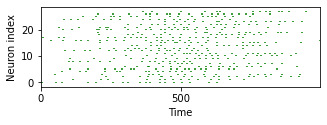

2.4647321701049805


In [ ]:
stim = stimulation_angle_90.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)

Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


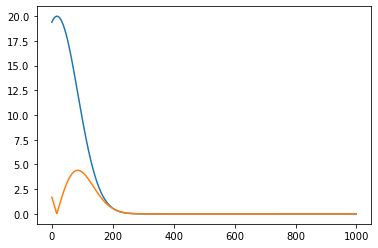

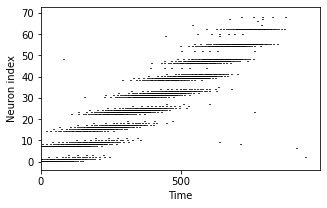

torch.Size([70, 999])


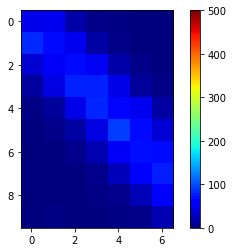

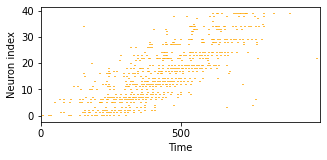

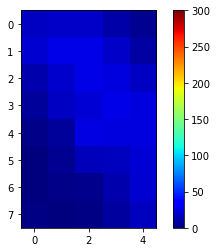

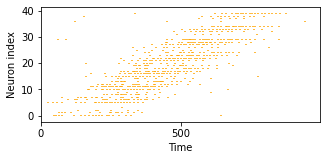

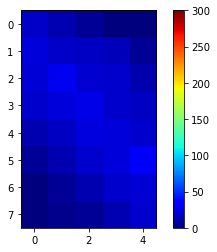

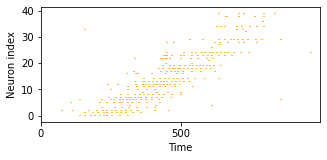

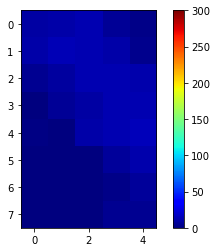

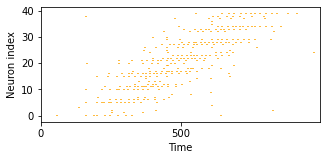

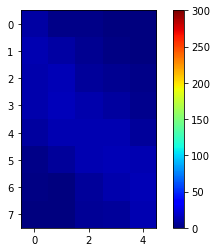

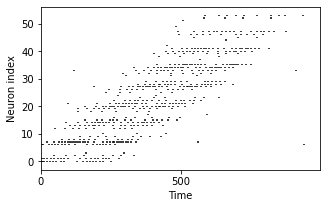

0 28


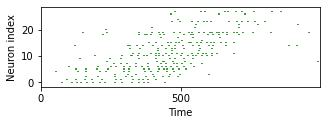

28 56


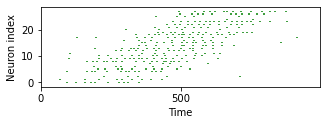

56 84


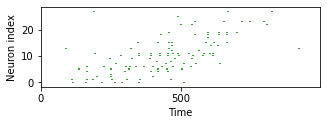

84 112


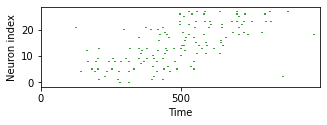

2.419006586074829


In [ ]:
stim = stimulation_left2right.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
               SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)


Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


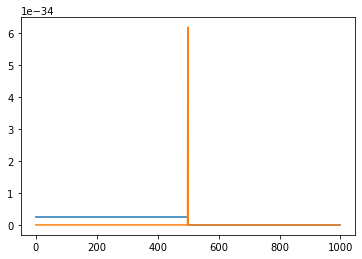

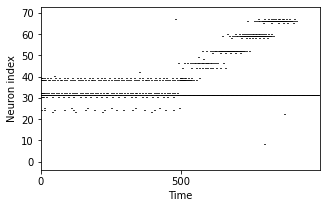

torch.Size([70, 999])


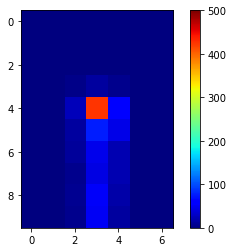

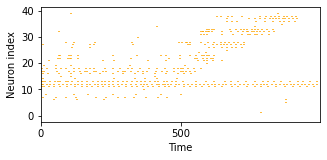

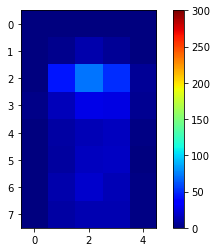

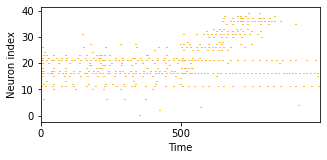

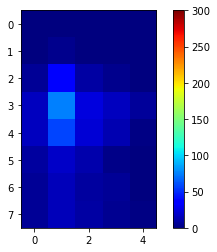

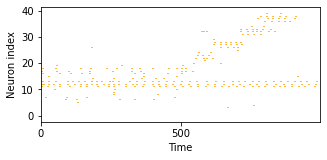

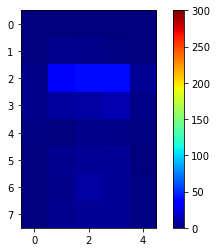

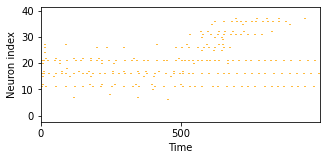

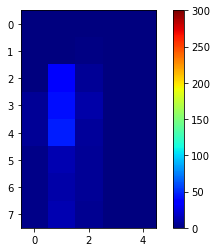

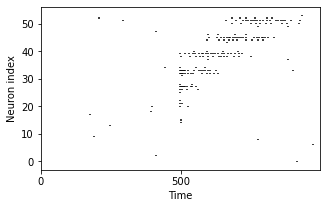

0 28


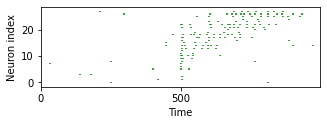

28 56


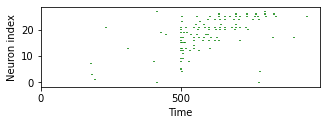

56 84


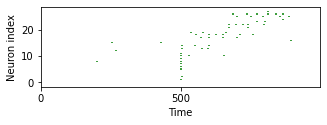

84 112


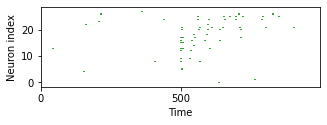

2.302611827850342


In [ ]:
stim = stimulation_drop.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
               SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)


In [ ]:
def elongated_stim(F, pixel_h, pixel_w, orientation='horizontal'):
    stim = torch.zeros((pixel_h, pixel_w), device=device)
    h_center = pixel_h // 2
    w_center = pixel_w // 2

    if orientation == 'horizontal':
        h_length = pixel_h // 10
        w_length = pixel_w
    elif orientation == 'vertical':
        h_length = pixel_h
        w_length = pixel_w // 10
    else:
        raise ValueError(
            "Invalid orientation. Choose 'horizontal' or 'vertical'.")

    h_start = h_center - h_length // 2
    h_end = h_center + h_length // 2
    w_start = w_center - w_length // 2
    w_end = w_center + w_length // 2

    stim[h_start:h_end, w_start:w_end] = F
    return stim


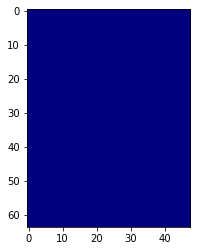

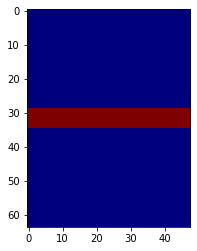

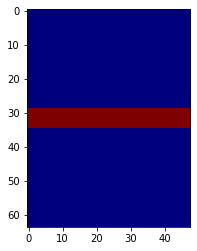

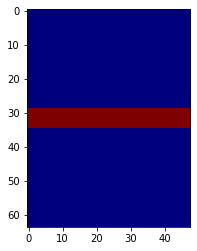

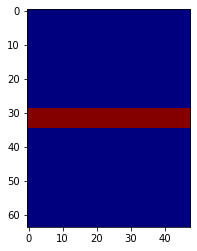

In [ ]:
stimulation_horizontal = torch.zeros((pixel_h, pixel_w, num_stim),device = device)

for i, F_i in enumerate(F_array):
    stim_dot = elongated_stim(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, orientation='horizontal')
    # Use 'vertical' for vertically elongated stimulus
    # stim_dot = elongated_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w, orientation='vertical')
    stimulation_horizontal[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_horizontal[:, :, i].cpu(),
                   cmap=cmap, vmin=0, vmax=max_F)
        
        plt.show()


Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


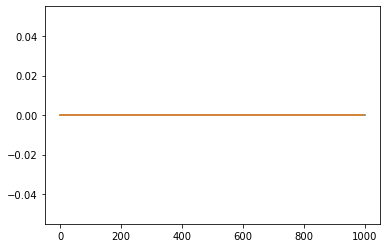

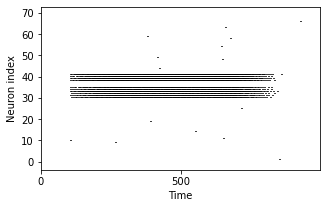

torch.Size([70, 999])


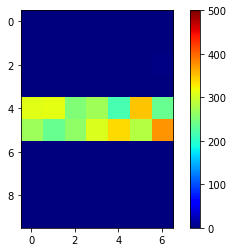

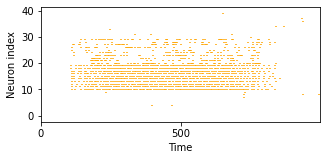

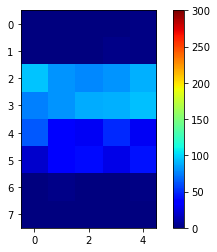

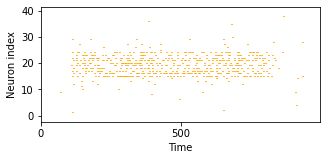

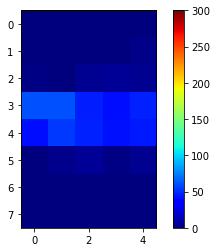

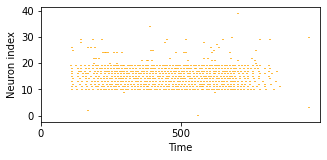

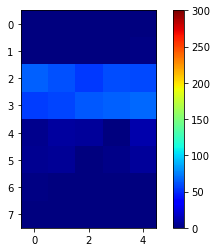

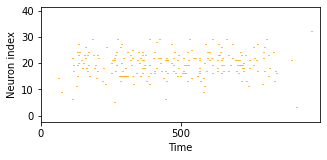

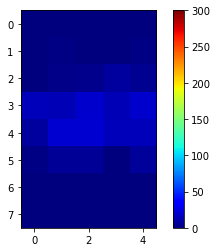

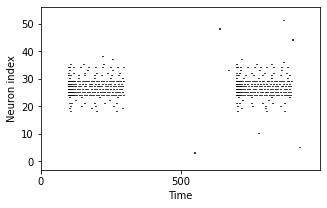

0 28


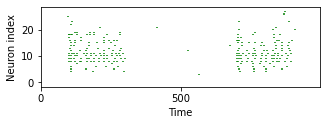

28 56


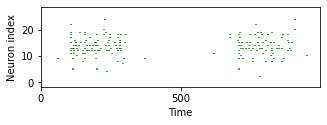

56 84


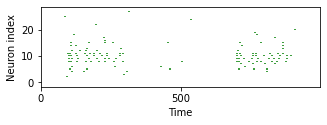

84 112


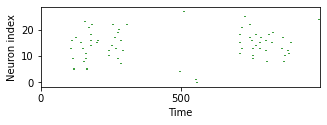

2.5266411304473877


In [ ]:
stim = stimulation_horizontal
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses,
               SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)


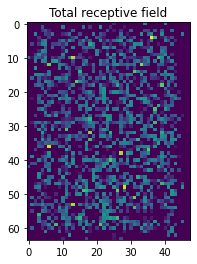

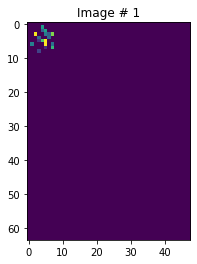

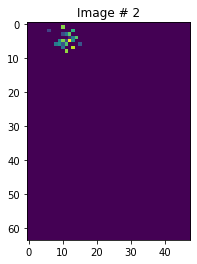

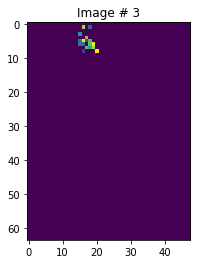

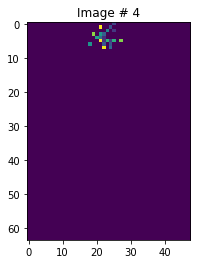

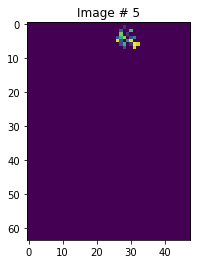

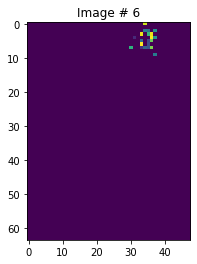

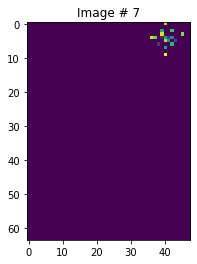

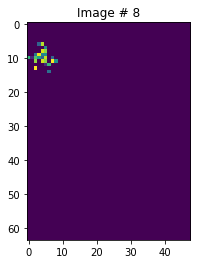

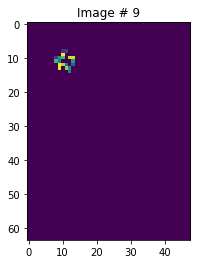

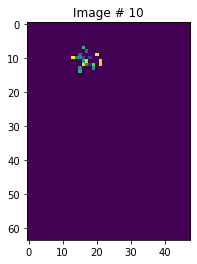

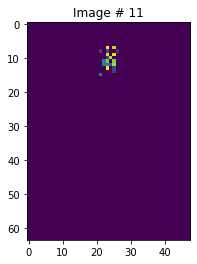

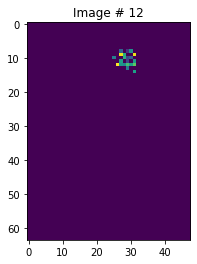

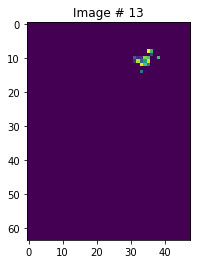

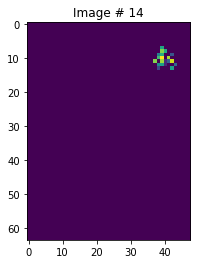

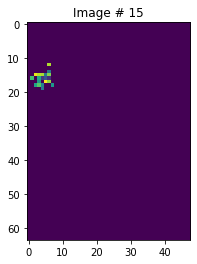

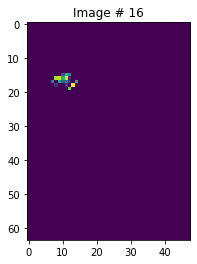

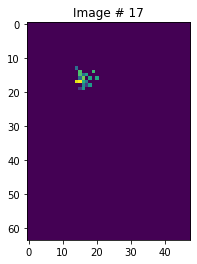

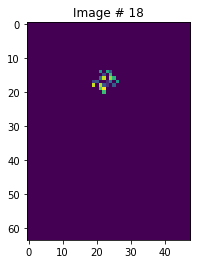

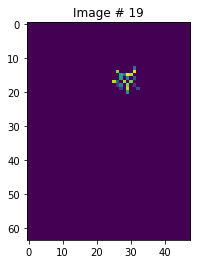

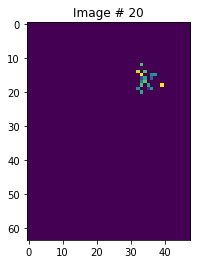

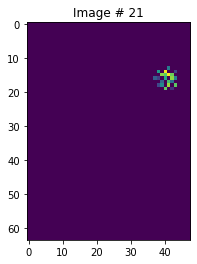

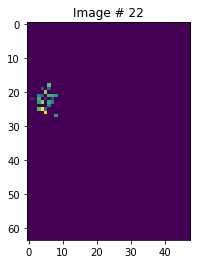

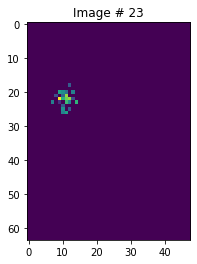

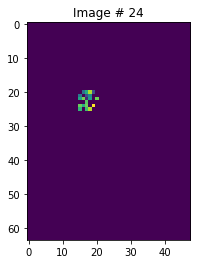

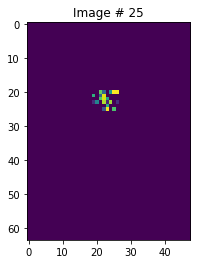

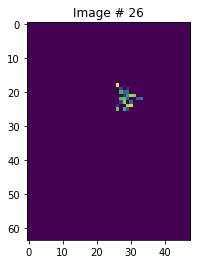

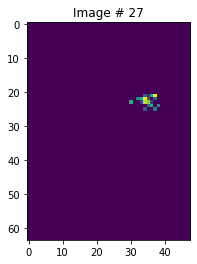

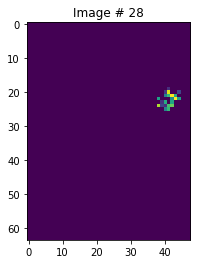

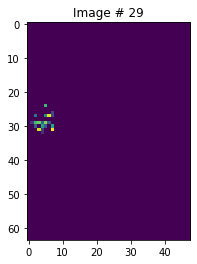

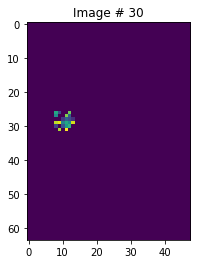

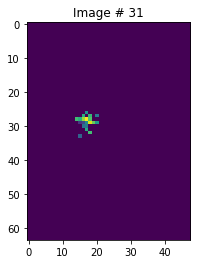

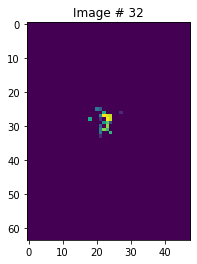

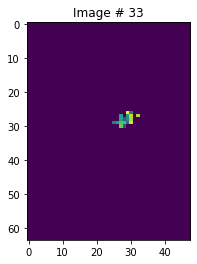

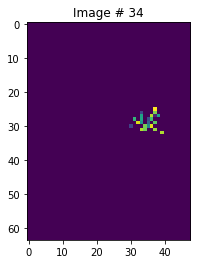

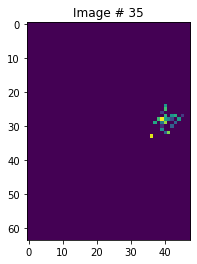

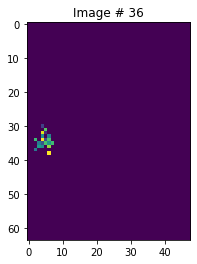

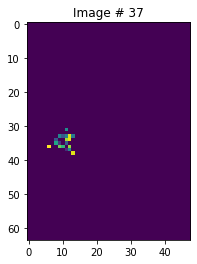

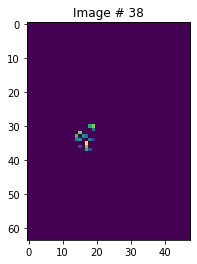

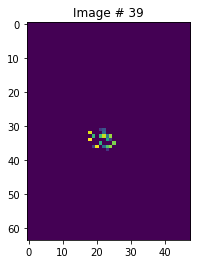

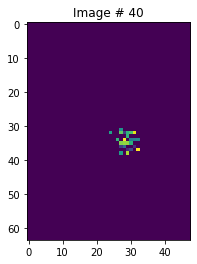

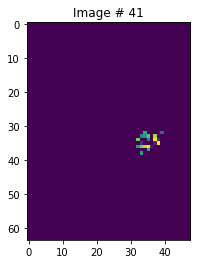

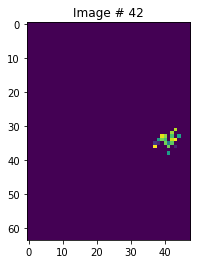

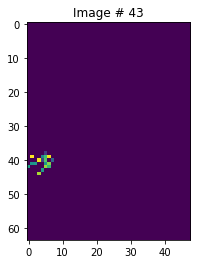

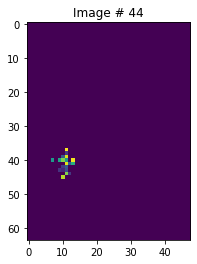

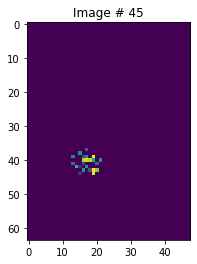

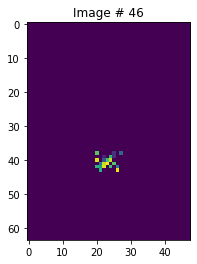

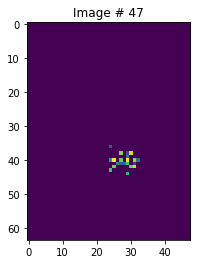

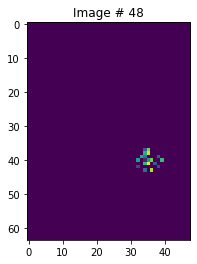

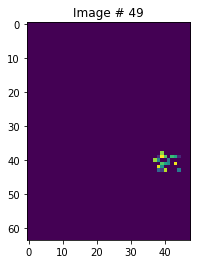

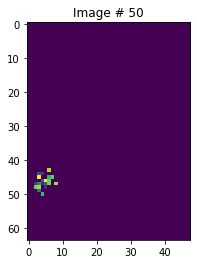

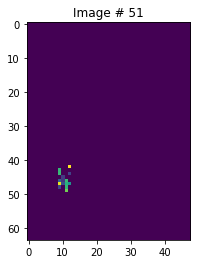

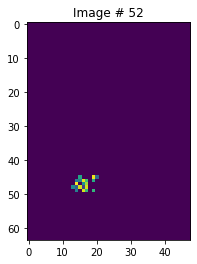

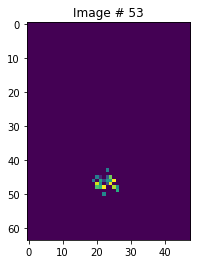

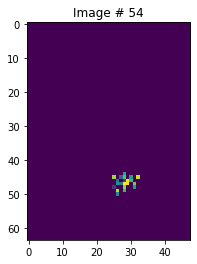

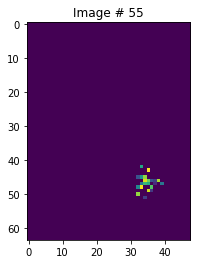

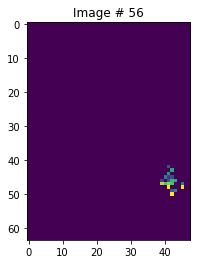

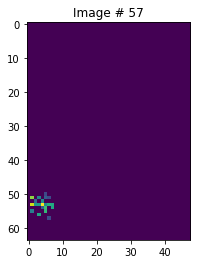

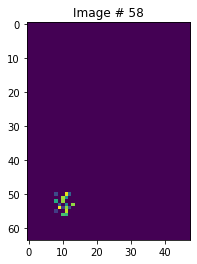

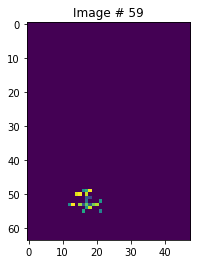

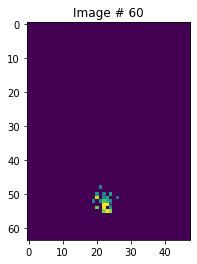

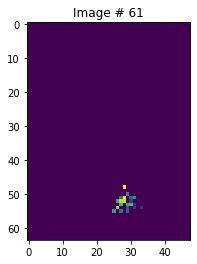

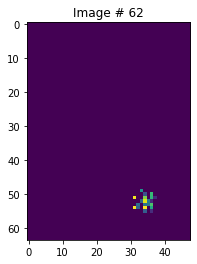

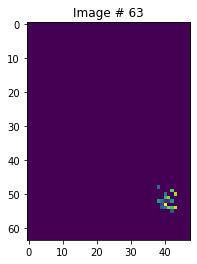

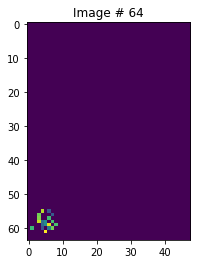

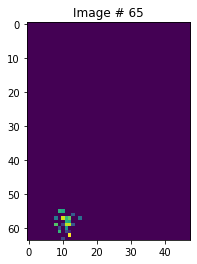

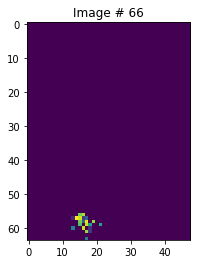

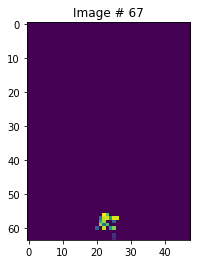

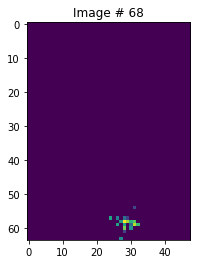

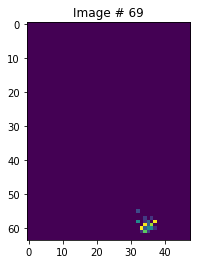

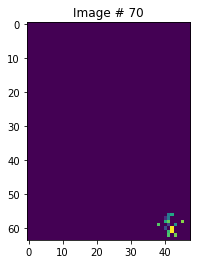

In [ ]:
plt.figure()
plt.imshow(torch.sum(SA_rf, axis=0).reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
plt.title('Total receptive field')
plt.show()

for i in range(len(SA_rf)):
    plt.figure()
    plt.imshow(SA_rf[i].reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()


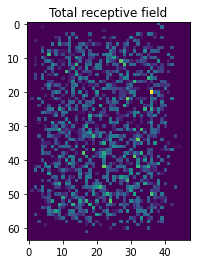

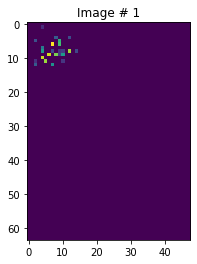

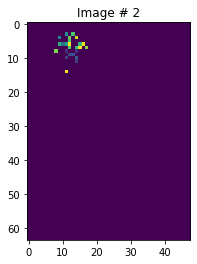

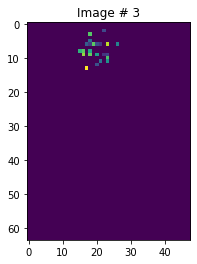

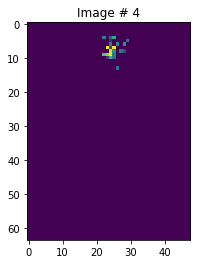

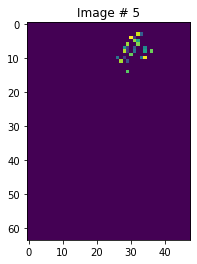

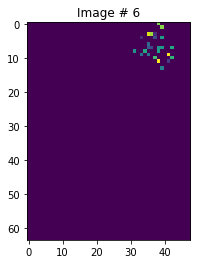

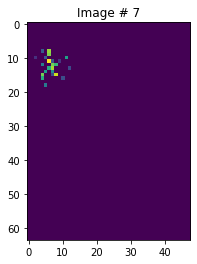

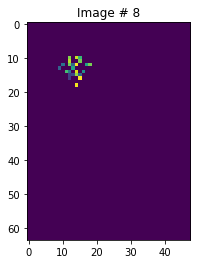

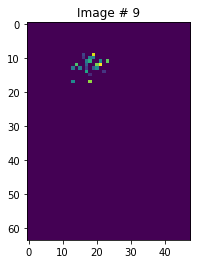

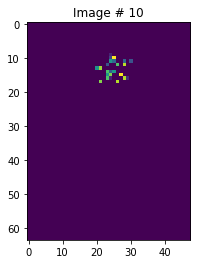

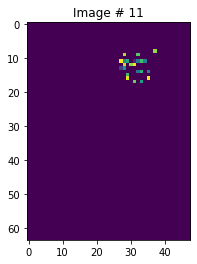

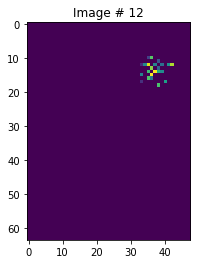

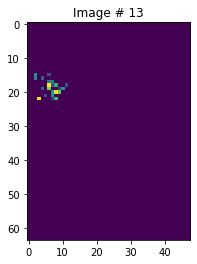

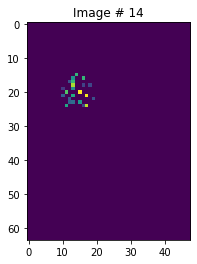

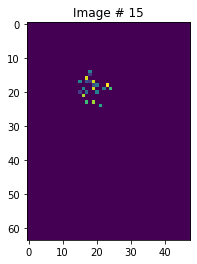

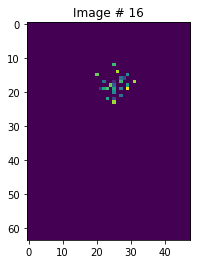

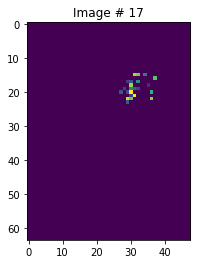

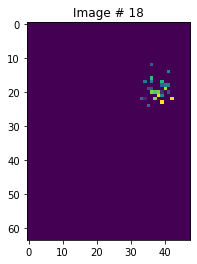

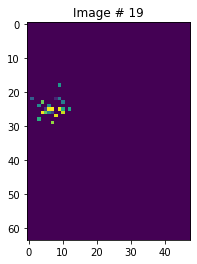

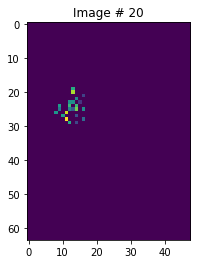

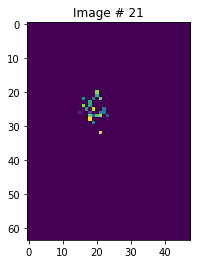

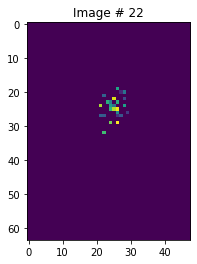

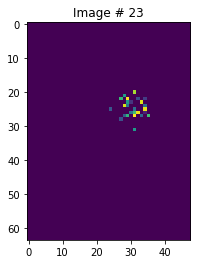

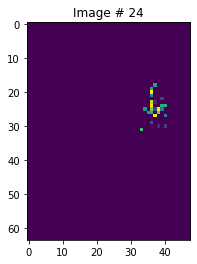

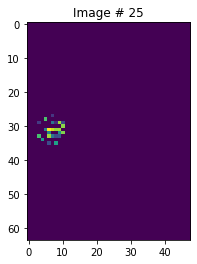

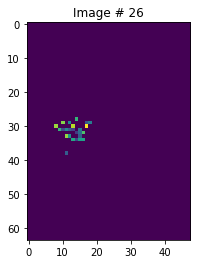

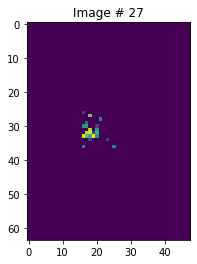

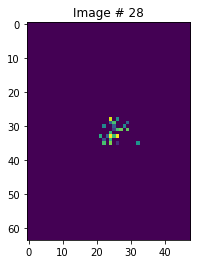

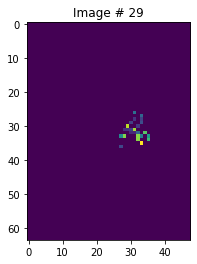

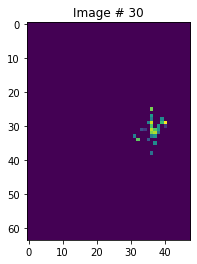

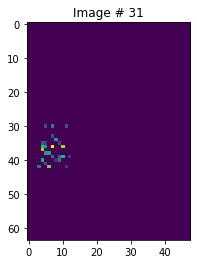

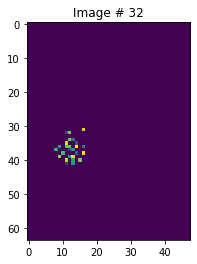

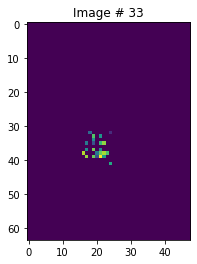

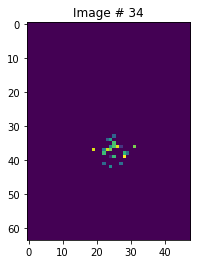

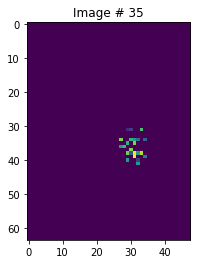

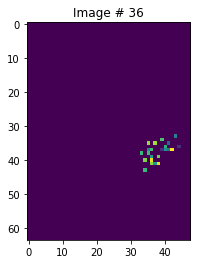

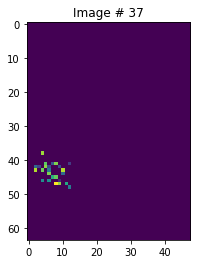

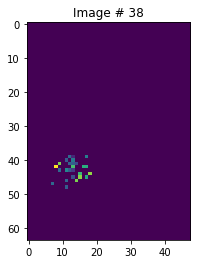

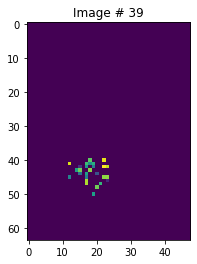

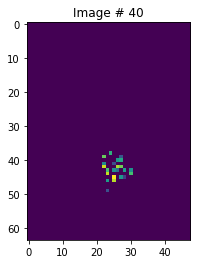

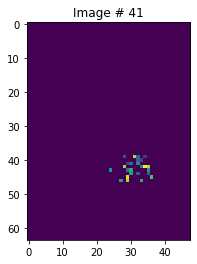

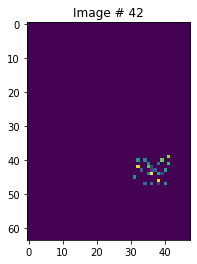

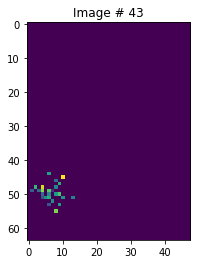

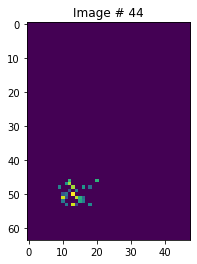

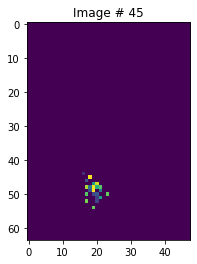

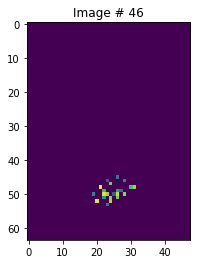

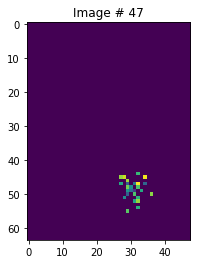

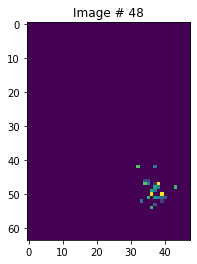

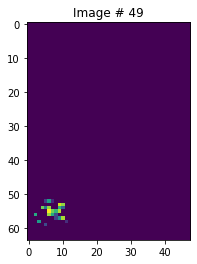

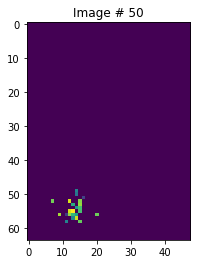

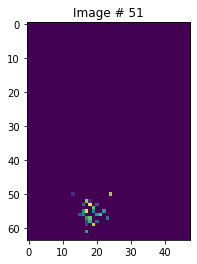

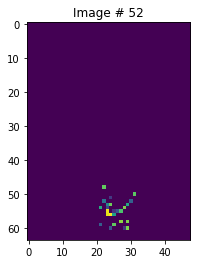

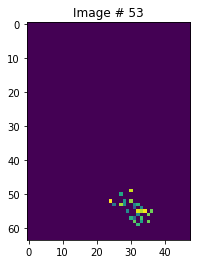

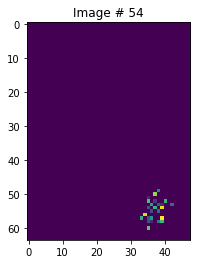

In [ ]:
plt.figure()
plt.imshow(torch.sum(RA_rf, axis=0).reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
plt.title('Total receptive field')
plt.show()

for i in range(len(RA_rf)):
    plt.figure()
    plt.imshow(RA_rf[i].reshape(pixel_h, pixel_w).cpu().numpy(), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()

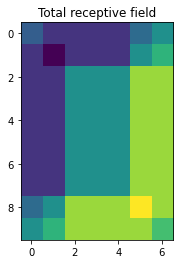

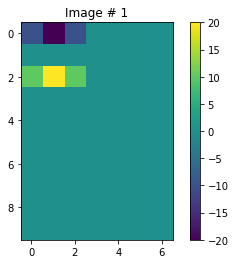

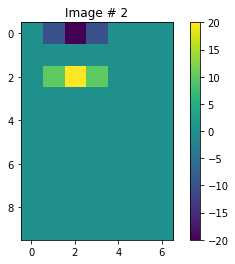

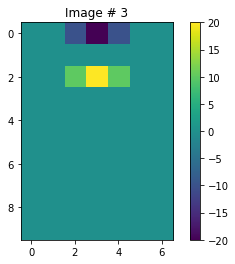

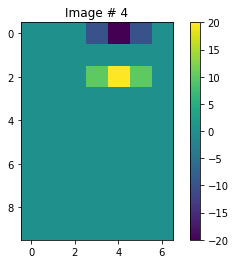

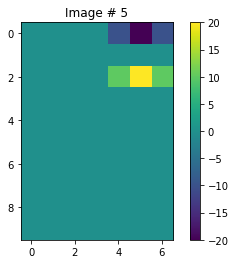

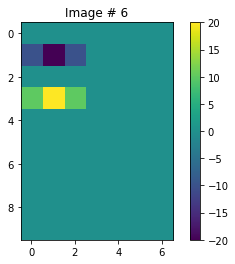

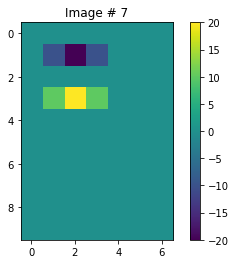

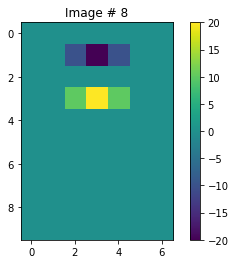

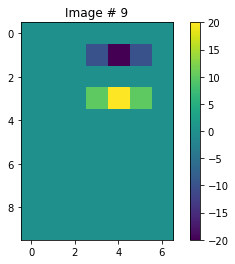

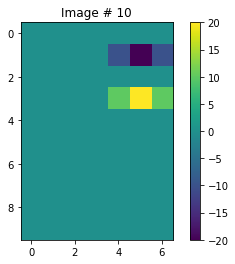

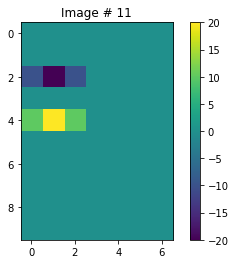

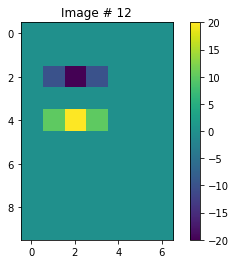

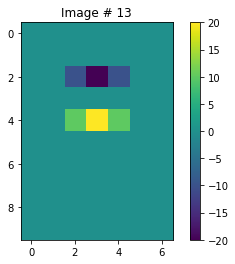

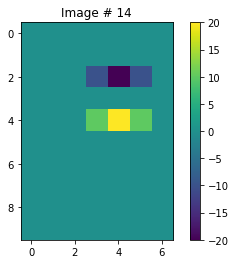

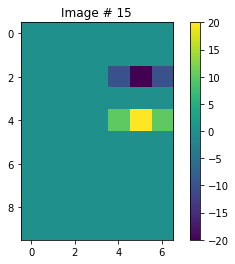

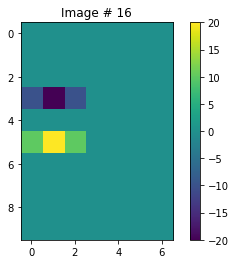

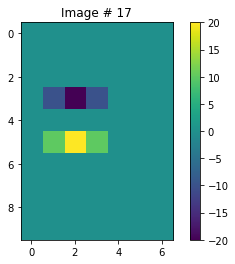

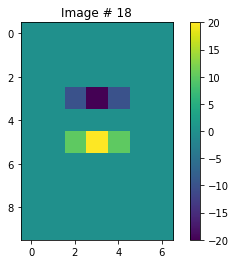

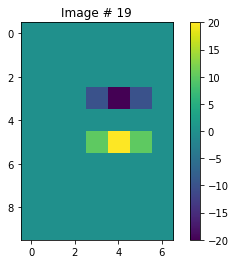

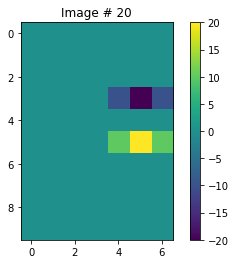

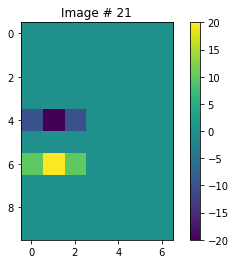

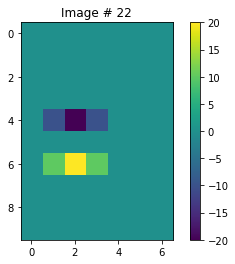

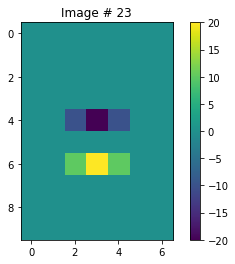

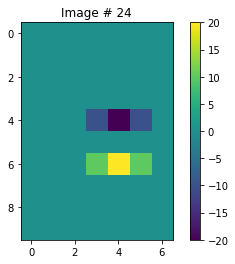

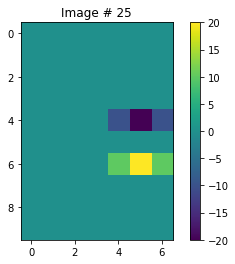

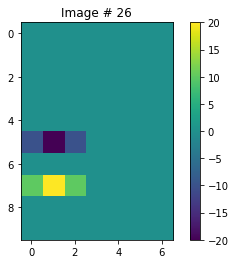

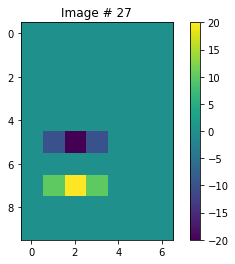

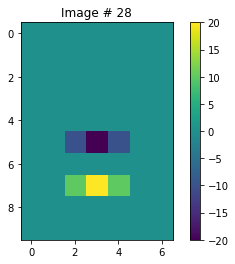

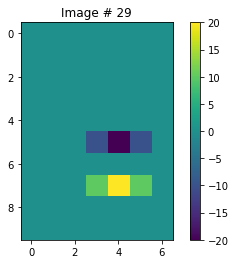

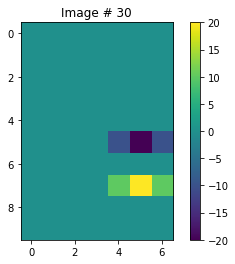

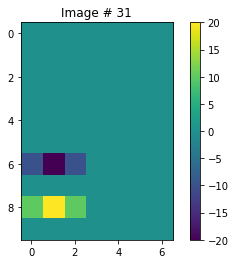

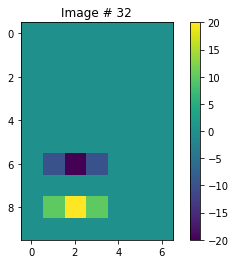

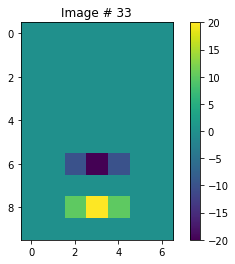

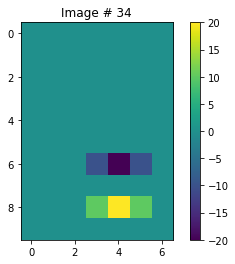

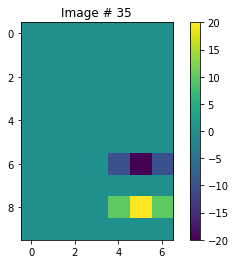

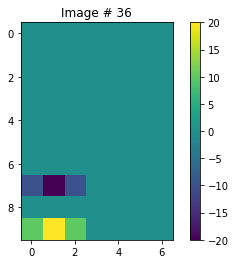

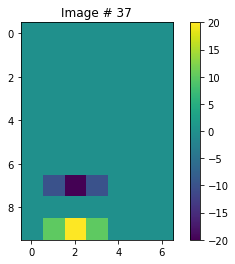

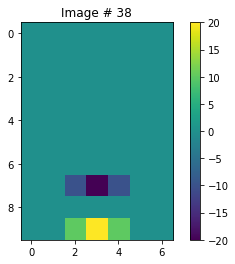

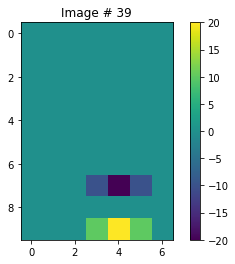

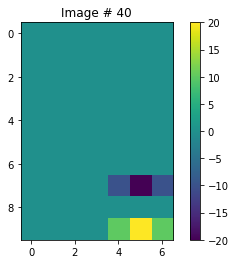

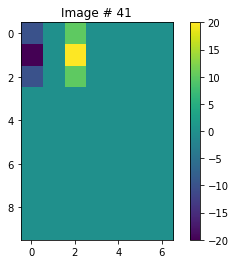

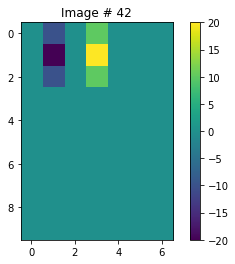

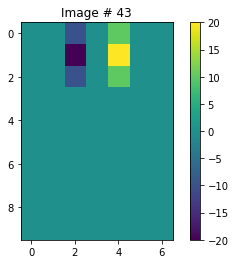

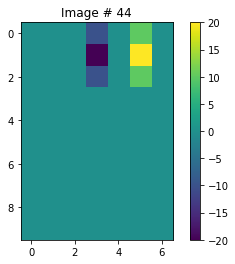

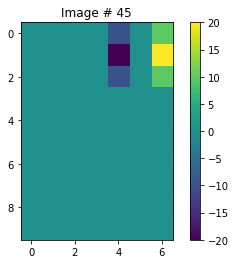

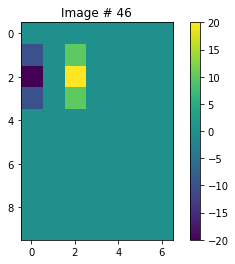

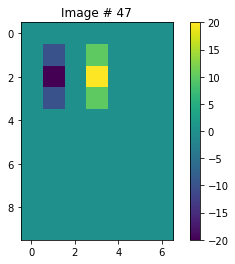

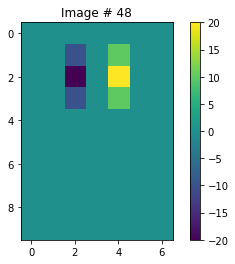

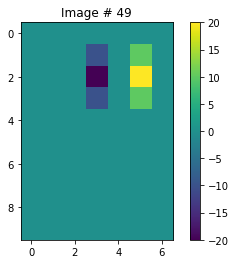

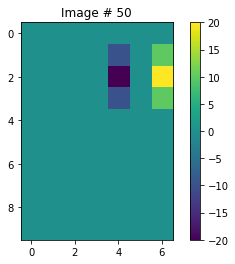

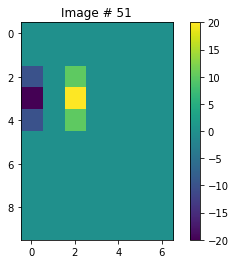

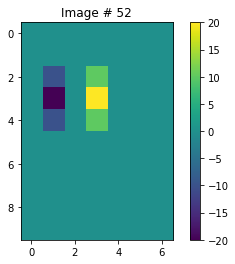

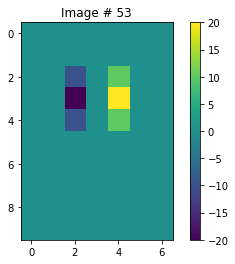

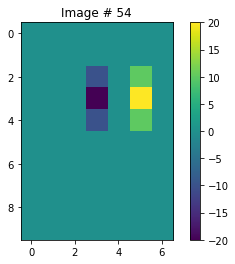

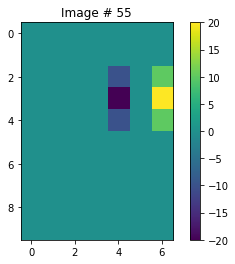

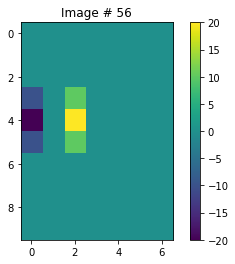

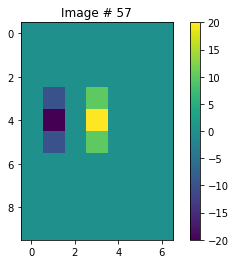

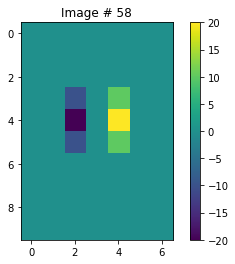

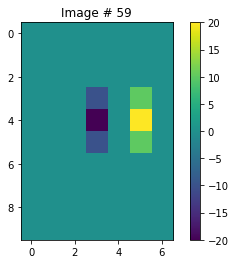

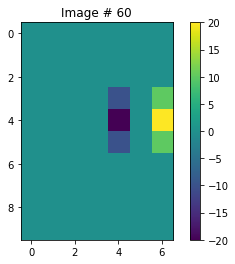

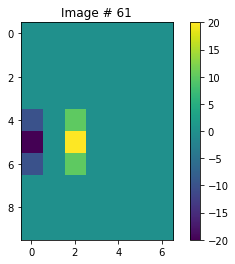

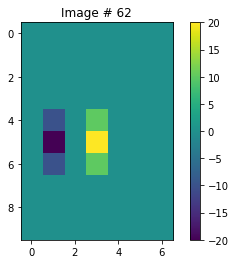

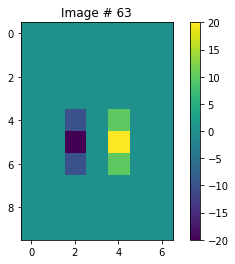

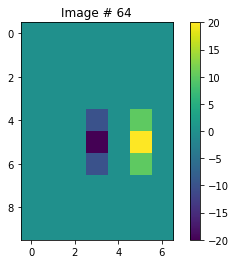

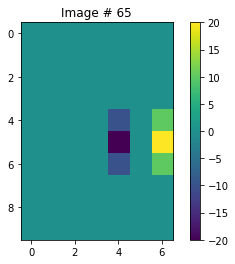

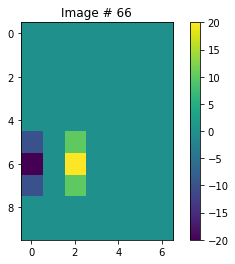

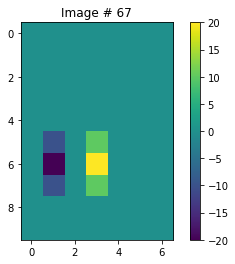

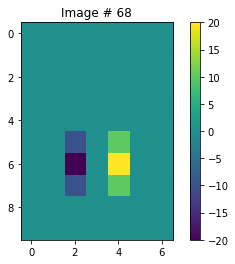

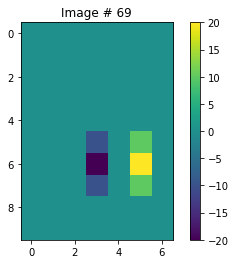

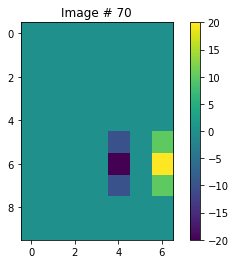

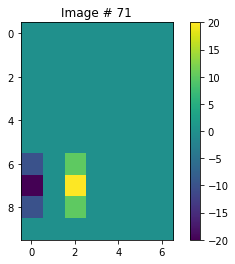

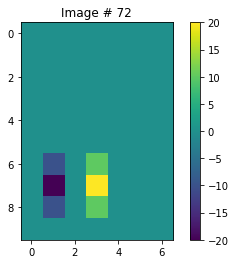

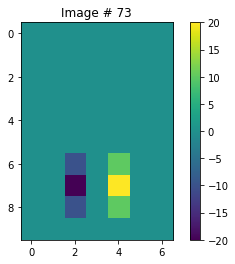

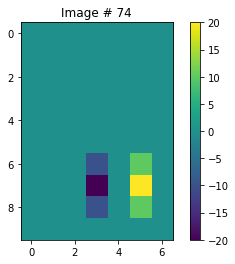

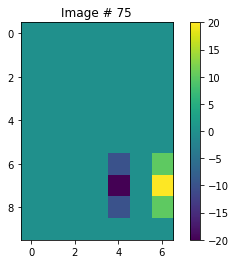

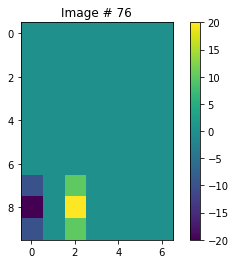

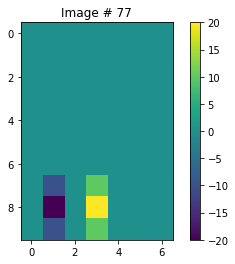

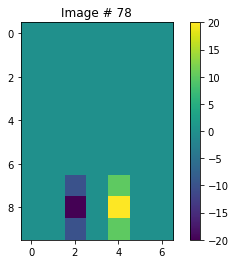

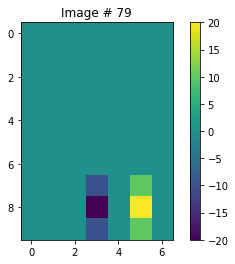

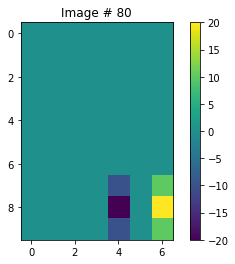

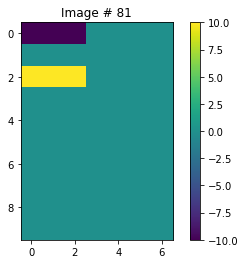

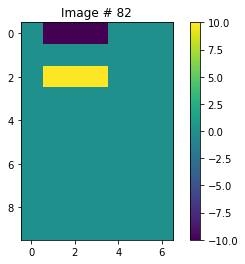

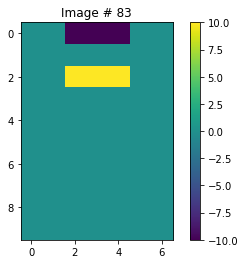

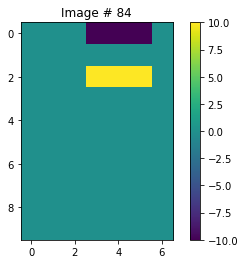

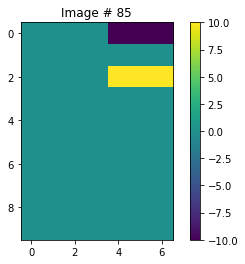

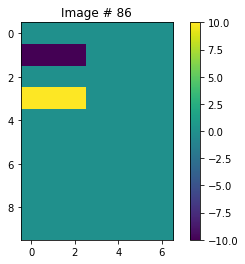

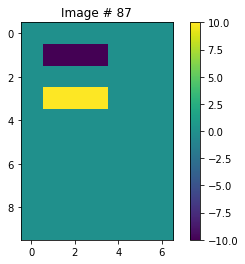

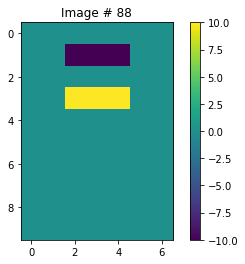

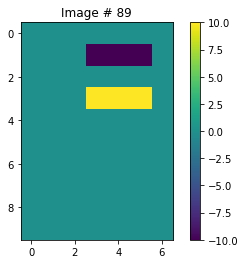

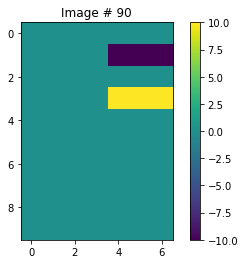

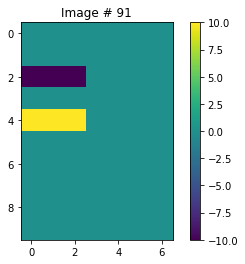

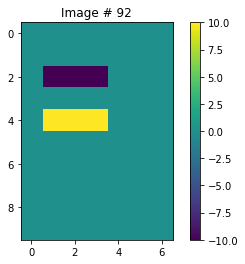

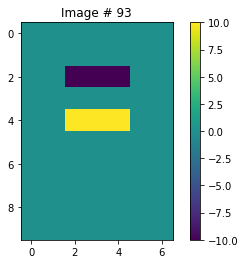

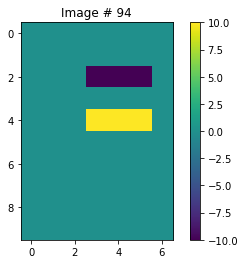

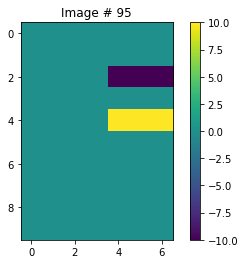

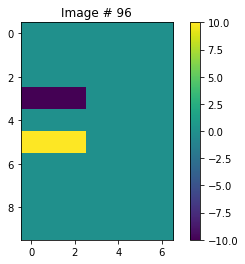

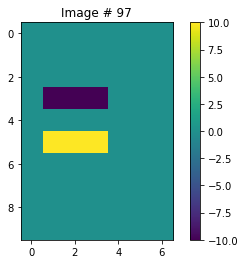

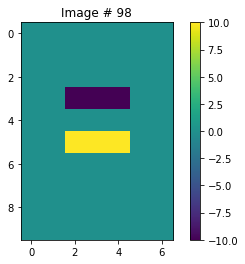

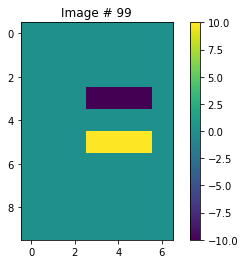

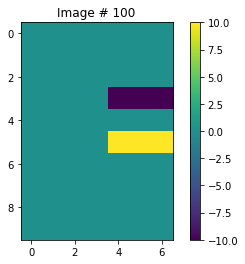

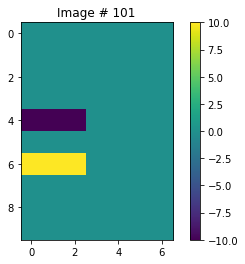

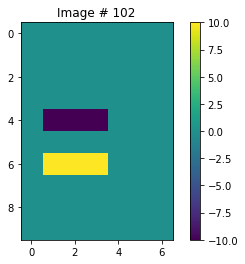

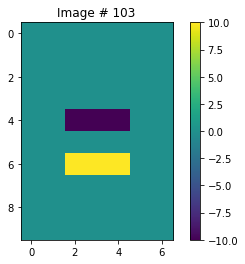

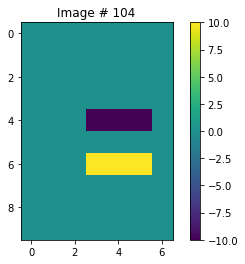

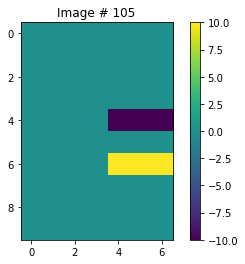

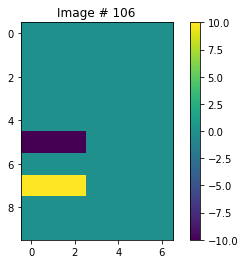

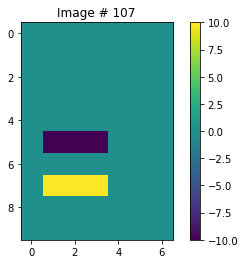

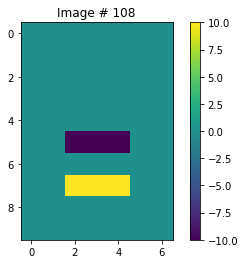

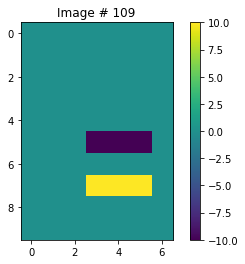

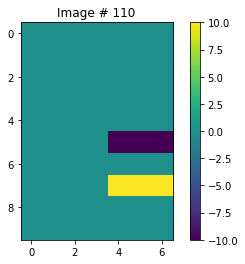

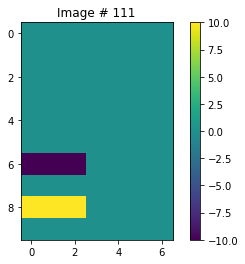

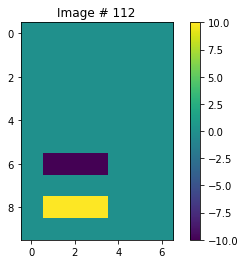

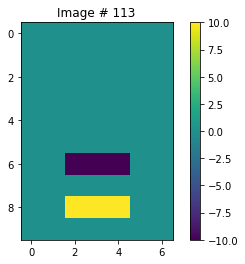

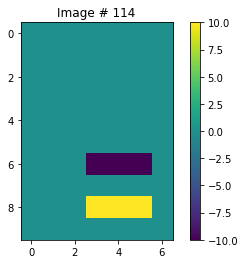

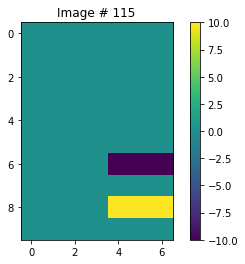

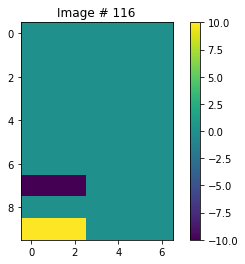

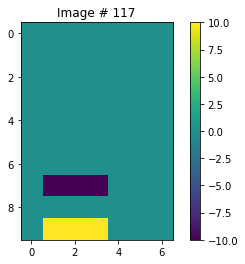

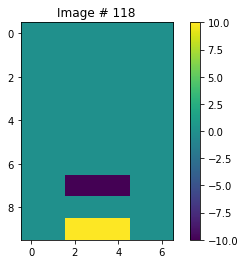

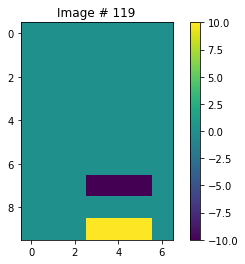

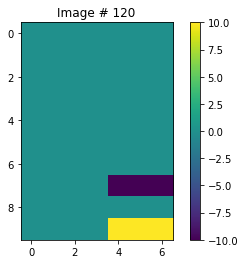

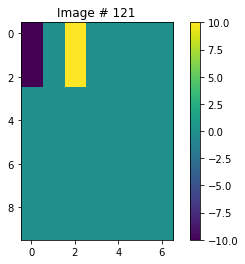

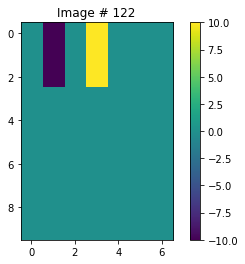

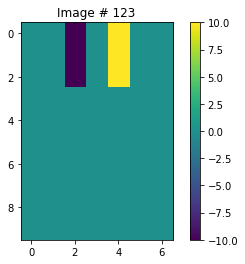

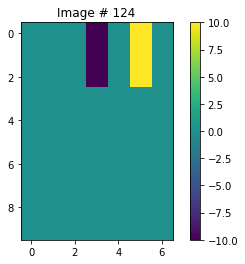

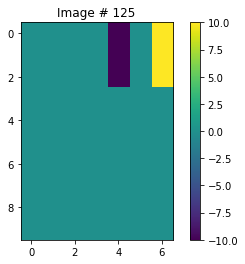

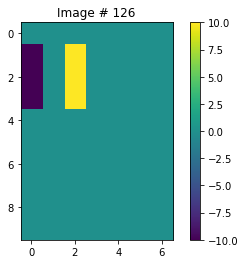

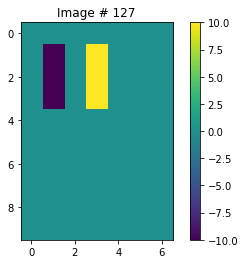

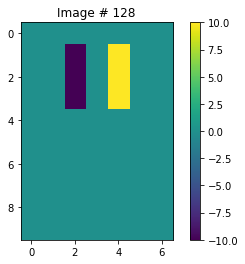

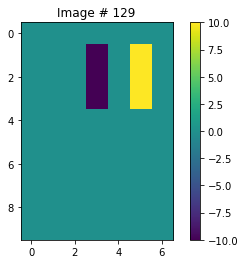

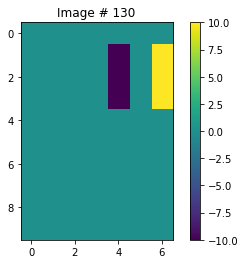

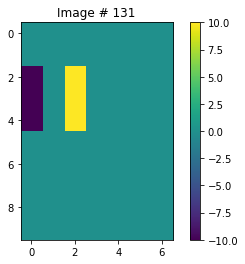

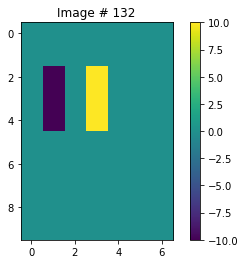

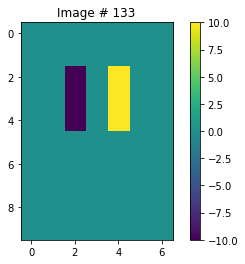

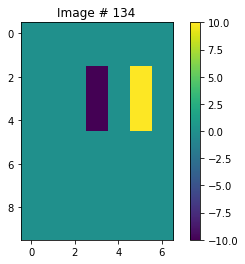

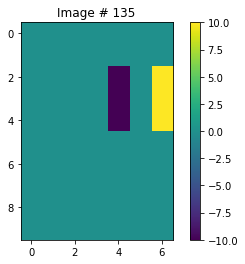

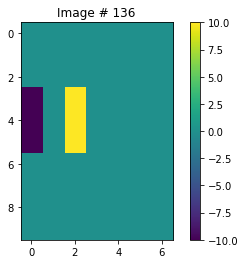

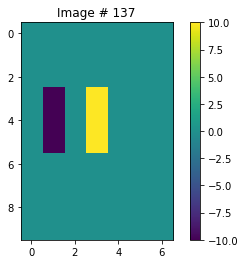

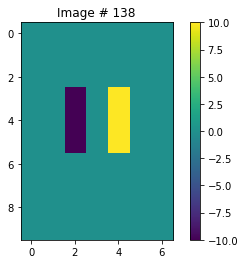

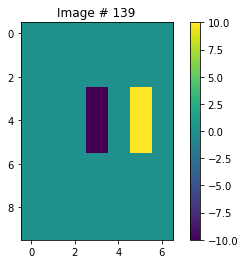

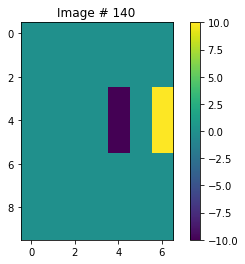

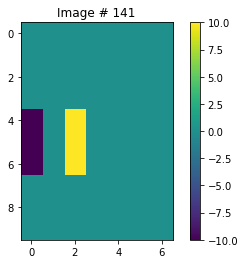

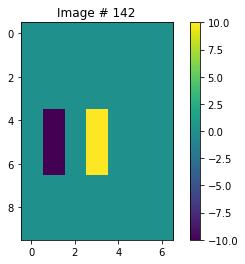

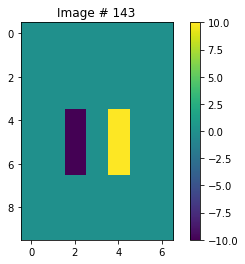

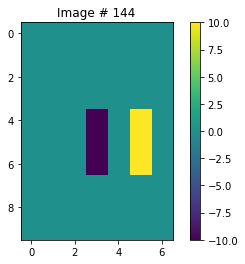

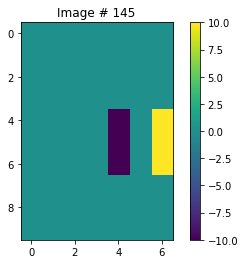

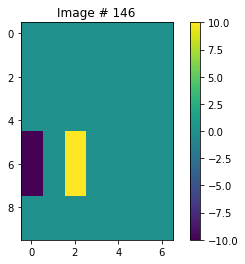

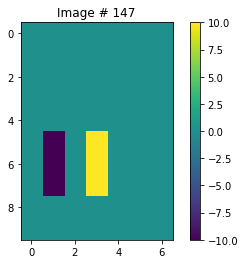

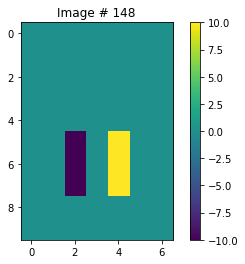

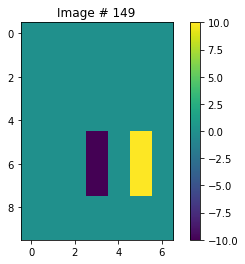

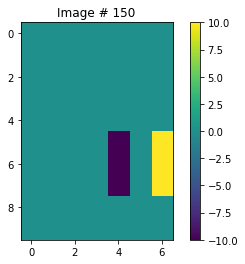

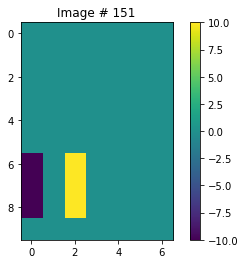

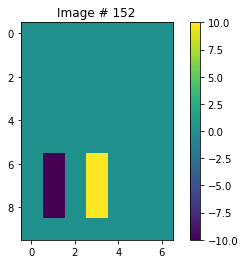

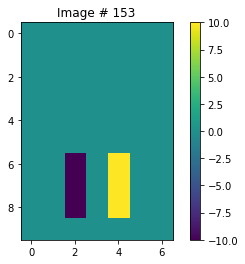

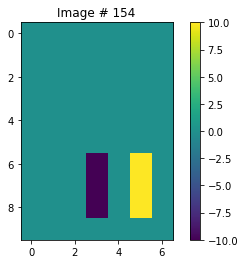

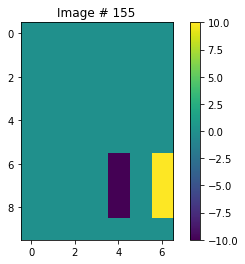

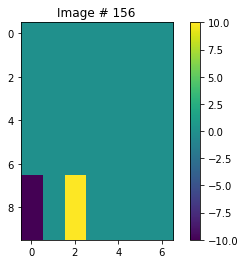

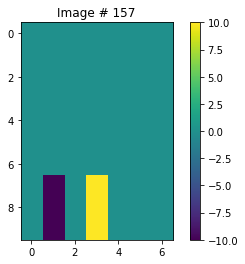

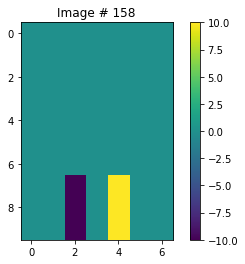

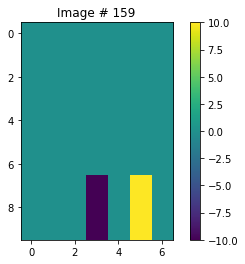

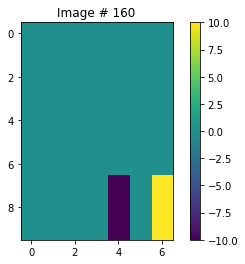

In [ ]:
plt.figure()
plt.imshow(torch.sum(SA_rf_top, axis=0).reshape(10, 7).cpu().numpy(), cmap='viridis')
plt.title('Total receptive field')
plt.show()

for i in range(len(SA_rf_top)):
    plt.figure()
    plt.imshow(SA_rf_top[i].reshape(10, 7).cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Image # {}'.format(i+1))
    plt.show()
